In [1]:
import pylab as plt
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.table import Table, join

import seaborn as sns

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

This notebook uses all the raw data from the CIGALE predictions and photoz catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. 

In [2]:
spies_moc = pymoc.MOC()
spies_moc.read('../../dmu0/dmu0_SpIES/data/Int_holes_Herschel-Stripe-82_irac_i1_O16_20180423Uni_SpIES_ch1andch2_HELP-coverage_MOCshela_irac_v1.3_flux_cat_MOC.fits')


Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_Herschel-Stripe-82/data/holes_Herschel-Stripe-82_irac_i1_O16_20180423.fits')

Final = Sel_func.intersection(spies_moc)

Final.write('./data/testMoc.fits', overwrite=True)

In [2]:
Final=pymoc.MOC()
Final.read('./data/testMoc.fits')

## Read in masterlist catalogue

In [3]:
flag_5=Table.read('../../dmu1/dmu1_ml_Herschel-Stripe-82/data/master_herschel-stripe-82_flag_opt_nir5_2020310.fits')


In [4]:
good = inMoc(flag_5['ra'],flag_5['dec'],Final)

In [9]:
flag_5[good]

ra,dec,help_id,f_irac_i1,ferr_irac_i1,f_irac_i2,ferr_irac_i2,flag_optnir_det
deg,deg,,,,,,
float64,float64,bytes27,float64,float64,float64,float64,int64
0.007540972779270765,0.3694032741676629,HELP_J000001.810+002209.852,30.80837360131247,8.536253456684241,22.654781300959208,8.470910246037025,6
0.00698120070617847,-0.3693473292226484,HELP_J000001.675-002209.650,63.900460801111535,3.336289004784528,57.77647325626383,4.317703621284579,6
0.005920930216326146,0.8277094841054147,HELP_J000001.421+004939.754,71.42381483070862,4.088549511715205,50.37355809355533,3.6157026368127885,6
0.05071234420844917,0.3425732351708978,HELP_J000012.171+002033.264,27.935768948590145,2.182618817188596,29.147353688467554,2.6880605952310566,5
0.035775677515772486,0.18234710859215017,HELP_J000008.586+001056.450,122.91065246434175,5.071151777036509,123.98433208427454,5.5712727815600935,5
0.0039016761719612436,-0.2196113198992692,HELP_J000000.936-001310.601,-4.534804261508181,5.848417062592018,14.206640910441884,2.334650947394617,6
0.007357141435392123,0.8897120166233953,HELP_J000001.766+005322.963,293.39453479414715,3.768783311425264,335.1028412167026,3.2726699977126668,5
0.041524539085770584,0.29495399265767425,HELP_J000009.966+001741.834,53.87498517347393,6.117883257863702,33.724542145620255,5.27919348445364,5


### Check number sources per beam


In [11]:
round(np.sqrt(Final.area_sq_deg), 2)

9.91

In [49]:
# n_prior = len(flag_5[good])#[flag_5[good]['f_irac_i1']>20])
# area = Final.area_sq_deg * 3600**2 # arcsec^2
fwhm = [18.15,25.15,36.3]

In [30]:
print('# priors for different f_irac cuts: \n' ,
      'ALL ', str(n_prior), '\n' ,     
      'f_irac_1 > 5 ', str(n_prior5), '\n',
      'f_irac_1 > 10 ', str(n_prior10), '\n',
      'f_irac_1 > 20 ', str(n_prior20))

# priors for different f_irac cuts: 
 ALL  3917403 
 f_irac_1 > 5  3316671 
 f_irac_1 > 10  2496451 
 f_irac_1 > 20  1615256


In [53]:
print(' ------------------  Density -------------------------------------------------------')
print(' -----------------------------------------------------------------------------------')
print('FWHM  ', '  ALL   |', ' f_irac1 > 5|', 'f_irac1 > 10|', 'f_irac1 > 20')
print(' -----------------------------------------------------------------------------------')
for i in fwhm:
    density = [x / area * (np.pi/(4*np.log(2)) * i**2) for x in [n_prior, n_prior5, n_prior10, n_prior20]]
    print(str(i), ' : ', str(round(density[0],3)),'  |', str(round(density[1],3)),'  |',str(round(density[2],3)),'  |', str(round(density[3],3)))

 ------------------  Density -------------------------------------------------------
 -----------------------------------------------------------------------------------
FWHM     ALL   |  f_irac1 > 5| f_irac1 > 10| f_irac1 > 20
 -----------------------------------------------------------------------------------
18.15  :  1.148   | 0.972   | 0.732   | 0.474
25.15  :  2.205   | 1.867   | 1.405   | 0.909
36.3  :  4.594   | 3.889   | 2.927   | 1.894


In [54]:
(14 * 22100) / 8500

36.4

In [5]:

pswfits='../../dmu19/dmu19_HS82_ATLAS/data/Stripe82-PSWmap-mosaic_MS-20200221.fits'#SPIRE 250 map
pmwfits='../../dmu19/dmu19_HS82_ATLAS/data/Stripe82-PMWmap-mosaic_MS-20200221.fits'#SPIRE 350 map
plwfits='../../dmu19/dmu19_HS82_ATLAS/data/Stripe82-PLWmap-mosaic_MS-20200221.fits'#SPIRE 500 map

pswfits_n='../../dmu19/dmu19_HS82_ATLAS/data/Stripe82-PSWmap-mosaic_MS-20200221-nebulised.fits'#SPIRE 250 map
pmwfits_n='../../dmu19/dmu19_HS82_ATLAS/data/Stripe82-PMWmap-mosaic_MS-20200221-nebulised.fits'#SPIRE 350 map
plwfits_n='../../dmu19/dmu19_HS82_ATLAS/data/Stripe82-PLWmap-mosaic_MS-20200221-nebulised.fits'#SPIRE 500 map

#output folder
output_folder='./'

In [6]:
from astropy.io import fits
from astropy import wcs

#-----250-------------
hdulist =fits.open(pswfits)
neb_hdulist = fits.open(pswfits_n)
im250phdu=hdulist[0].header
im250hdu=neb_hdulist[0].header
im250=neb_hdulist[0].data*1.0E3 #convert to mJy
nim250 = hdulist['ERROR'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(neb_hdulist[0].header)
pixsize250=3600.0*w_250.wcs.cdelt[1] #pixel size (in arcseconds)
hdulist.close()
neb_hdulist.close()


#-----350-------------
hdulist =fits.open(pmwfits)
neb_hdulist = fits.open(pmwfits_n)
im350phdu=hdulist[0].header
im350hdu=neb_hdulist[0].header
im350=neb_hdulist[0].data*1.0E3 #convert to mJy
nim350 = hdulist['ERROR'].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(neb_hdulist[0].header)
pixsize350=3600.0*w_350.wcs.cdelt[1] #pixel size (in arcseconds)
hdulist.close()
neb_hdulist.close()


#-----500------------
hdulist =fits.open(plwfits)
neb_hdulist = fits.open(plwfits_n)
im500phdu=hdulist[0].header
im500hdu=neb_hdulist[0].header
im500=neb_hdulist[0].data*1.0E3 #convert to mJy
nim500 = hdulist['ERROR'].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(neb_hdulist[0].header)
pixsize500=3600.0*w_500.wcs.cdelt[1] #pixel size (in arcseconds)
hdulist.close()
neb_hdulist.close()


In [7]:
pixsize250

6.000000000000001

In [8]:
# obtain wcs info of each image
wcs_temp250 = wcs.WCS(im250hdu)
wcs_temp350 = wcs.WCS(im350hdu)
wcs_temp500 = wcs.WCS(im500hdu)

wcs_list = [wcs_temp250, wcs_temp350, wcs_temp500]
im = ['250', '350','500']
pix_size = [pixsize250, pixsize350, pixsize500]
naxis_list = []
   
for index, wcs_ in enumerate(wcs_list):
    naxis = wcs_._naxis
    naxis_list.append(naxis)

coord = {'250':naxis_list[0], '350':naxis_list[1], '500':naxis_list[2]}
for key, val in coord.items():
    print(key, val)

250 [30706, 11550]
350 [23033, 8671]
500 [15355, 5781]


## Set XID+ prior class

This has been run on Apollo, applied iteratively to each cutout

In [10]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=Final)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(flag_5[good]['RA'], flag_5[good]['DEC'], 'master_herschel-stripe-82_flag_opt_nir5_2020310.fits',ID=flag_5[good]['help_id'] )#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=Final)
prior350.prior_cat(flag_5[good]['RA'], flag_5[good]['DEC'], 'master_herschel-stripe-82_flag_opt_nir5_2020310.fits',ID=flag_5[good]['help_id'] )
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=Final)
prior500.prior_cat(flag_5[good]['RA'], flag_5[good]['DEC'], 'master_herschel-stripe-82_flag_opt_nir5_2020310.fits',ID=flag_5[good]['help_id'] )
prior500.prior_bkg(-5.0,5)

MemoryError: Unable to allocate 2.64 GiB for an array with shape (11550, 30706) and data type int64

In [17]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [2]:
import numpy as np
pixsize=np.array([6.0,8.0,12.0])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [12]:
np.arange(0,101,1)*1.0

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100.])

In [11]:
pind500

array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
       0.83333333, 0.91666667, 1.        , 1.08333333, 1.16666667,
       1.25      , 1.33333333, 1.41666667, 1.5       , 1.58333333,
       1.66666667, 1.75      , 1.83333333, 1.91666667, 2.        ,
       2.08333333, 2.16666667, 2.25      , 2.33333333, 2.41666667,
       2.5       , 2.58333333, 2.66666667, 2.75      , 2.83333333,
       2.91666667, 3.        , 3.08333333, 3.16666667, 3.25      ,
       3.33333333, 3.41666667, 3.5       , 3.58333333, 3.66666667,
       3.75      , 3.83333333, 3.91666667, 4.        , 4.08333333,
       4.16666667, 4.25      , 4.33333333, 4.41666667, 4.5       ,
       4.58333333, 4.66666667, 4.75      , 4.83333333, 4.91666667,
       5.        , 5.08333333, 5.16666667, 5.25      , 5.33333333,
       5.41666667, 5.5       , 5.58333333, 5.66666667, 5.75      ,
       5.83333333, 5.91666667, 6.        , 6.08333333, 6.16666

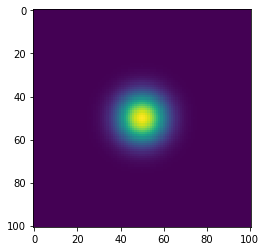

In [5]:
import matplotlib.pyplot as plt
plt.imshow(prf250)

In [27]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=9
tiles=moc_routines.get_HEALPix_pixels(order,prior250.sra,prior250.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior250.sra,prior250.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./data/'
outfile=output_folder+'Master_prior.pkl'
xidplus.io.pickle_dump({'priors':[prior250,prior350,prior500],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},outfile)
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()